In [14]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

In [15]:
"""10 Ensemble member """

simulation_files = [glob('data/*polex0*'), glob('data/*polex1*'), glob('data/*polex2*')]

In [16]:
simulation_array = {}
for i, polex_files in enumerate(simulation_files):
    simulation_array['Polex%d'%i] = []
    for ensemble in polex_files:
        simulation_array['Polex%d'%i].append(xr.open_dataset(ensemble))

In [17]:
all_data = np.array(list(simulation_array.values()))
all_data.shape

(3, 10, 3)

In [18]:
array = simulation_array['Polex0'][0]
pressure_field = np.array(array.mslp)
t,rlat,rlon = np.array(array.time),np.array(array.rlat),np.array(array.rlon)

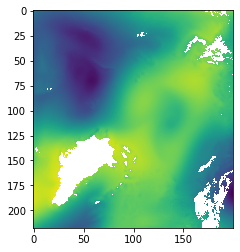

In [19]:
plt.imshow(pressure_field[20,:,::-1].T)

In [20]:

a = 20070301
b = 20071201

def time_mask(arr):
    #print(arr)
    #print(arr[(arr>=a & arr<b)])
    return arr[np.logical_and(arr>=a, arr<b)]#arr[(arr<a)|(b<=arr)]

In [21]:
float(array.time[0])

20070101.375

In [22]:
day_mask = np.arange(0)

In [23]:
feature_generators = {
    'mean':np.nanmean, 
    'max':np.nanmax, 
    'min': np.nanmin,
    'std': np.nanstd,
    'lower quartile': lambda x:np.nanquantile(x.flatten(),1/4),
    'upper quartile': lambda x:np.nanquantile(x.flatten(),3/4)
}

In [24]:
def grad_strength(pressure_map):
    x,y = np.gradient(pressure_map)
    return np.sqrt(x**2 + y**2) # norm

def grad_angle(pressure_map):
    x,y = np.gradient(pressure_map)
    return np.arctan2(y,x)

In [161]:
from joblib import Memory
memory = Memory("/tmp/joblib", verbose=0)


spatial_features = feature_generators.copy()

# das da ist gefährlich, erst https://joblib.readthedocs.io/en/latest/memory.html lesen!
# @memory.cache
def gen_features(pressure_map):
    features = []
    # pressure
    for fun in feature_generators.values():
        features.append(fun(pressure_map))

    # gradient strenght (~wind)
    magnitude = grad_strength(pressure_map)
    for fun in feature_generators.values():
        features.append(fun(magnitude))

    # gradient direction (~wind)
    magnitude = grad_angle(pressure_map)
    for fun in feature_generators.values():
        features.append(fun(magnitude))

    return features

In [163]:
spatial_data = []

for polex_index, polex in enumerate(simulation_array):
    sim = simulation_array[polex]
    spatial_data.append([])
    for ensemble_index, ensemble in enumerate(tqdm(sim)):
        spatial_data[-1].append([])
        previous_day = None
        
        days = time_mask(np.array(ensemble.time))
        for day_index, day in enumerate(days):
            if day_index < 6 or day_index > len(days)-7:
                continue
            
            features = []
            for i in range(-5,6):
                pressure_map = np.array(ensemble.mslp.loc[days[day_index-i],:,:])
                features.extend(gen_features(pressure_map))
                
            spatial_data[-1][-1].append(features)
    
spatial_data = np.array(spatial_data)


100%|██████████| 10/10 [00:39<00:00,  3.99s/it]

100%|██████████| 10/10 [00:39<00:00,  3.99s/it]

100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


In [179]:
spatial_data.shape

(3, 10, 263, 198)

In [180]:
feature_names = list(feature_generators.keys())
feature_names = ["pressure " + i for i in feature_names] + ["gradient strenght " + i for i in feature_names] + ["gradient direction " + i for i in feature_names]
feature_names =  ["today's " + i for i in feature_names] + ["yesterday's " + i for i in feature_names] + ["tomorw's " + i for i in feature_names] 

In [181]:
#

In [182]:
count_features = spatial_data.shape[-1]

In [264]:
X = spatial_data.reshape([3,-1, count_features])
y = [0]*X[0,:,:].shape[0] + [1]*X[1,:,:].shape[0] #+ [2]*X[2,:,:].shape[0]

In [265]:
X = X[0:2,:,:].reshape([-1,count_features])

In [266]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_auc_score
from tqdm import tqdm

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True, stratify=y)

In [268]:
rf = ExtraTreesClassifier()#RandomForestClassifier(n_estimators=1000, max_depth=100, random_state=0)

In [269]:
# TODO:
# mit KNeighborsClassifier(5) bekommt man eine AUC von 0.6, d.h. da gibt es Unterschiede!
# ExtraTreesClassifier bekommt fast AUC 0.6
# den Bäumen würden weniger features entgegenkommen - z.B. mrMR könnte hier helfen
# zwingend notewendig sind noch weitere Zeitattribute, etwa zeitlicher Gradient, etc.

In [270]:
rf.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [271]:
X_train.shape

(3945, 198)

In [272]:
y_pred = rf.predict(X_test)
roc_auc_score(y_test,y_pred)

0.5512426383163777

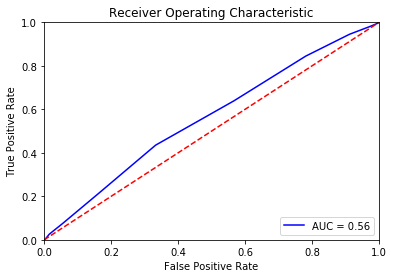

In [273]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
model = rf
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[[439 219]
 [371 286]]


TypeError: can only concatenate list (not "range") to list

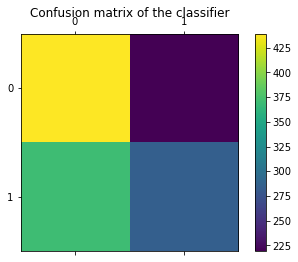

In [274]:
from sklearn.metrics import confusion_matrix

labels = range(2)
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [275]:
importances = rf.feature_importances_
sort_mask = np.argsort(importances)

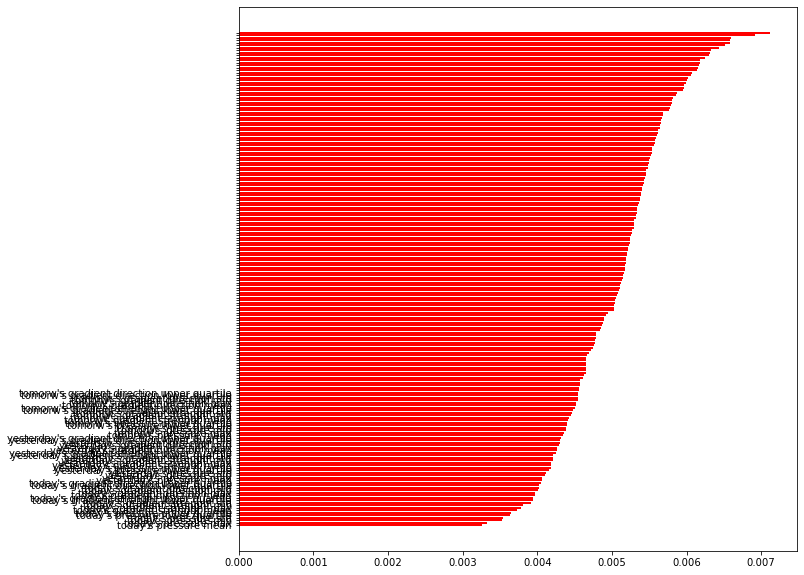

In [276]:
plt.figure(figsize=(10,10))
plt.barh(range(X.shape[1]), importances[sort_mask],
       color="r",  align="center") # yerr=std[indices],
plt.yticks(range(X.shape[1]), feature_names)
#plt.ylim([-1, X.shape[1]])
plt.show()